# Introduction

This notebook is a testbed for the numerous models to derive bio-geophysical parameters from spectral reflectance data of water bodies. 
First, a set of spectra is generated with the bio-optical model of Albert & Mobley (2003) and known parameters (e.g., concentrations of optically activate water constituents or depth), then the different models are applied to the simulated data to test their performance for the given set of parameters.
This notebook can be used to perform sensitivity analyses (e.g., to test how models perform under defined conditions) or for debugging purposes.

In [1]:
import os
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import lmfit
import scipy
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error, r2_score

import bio_optics
from bio_optics.models import model, spm, turbidity, chl, cdom, bathymetry, qaa, hope, sbop
from bio_optics.helper import resampling, utils, owt, indices, plotting, spectral_mixture

# Simulation

We use the bio-optical model of Albert & Mobley (2003) in forward mode to simulate a number of spectra. The parameters are drawn from random distributions of defined shapes, which can be changed to simulate different conditions.

## Preparation

In [2]:
# Define wavelength range and sampling rate
wavelengths=np.arange(400,900)

In [3]:
# Extraterrestrial solar irradiance
E_0_res = resampling.resample_E_0(wavelengths=wavelengths)

# Atmosphere 
a_oz_res = resampling.resample_a_oz(wavelengths=wavelengths)
a_ox_res = resampling.resample_a_ox(wavelengths=wavelengths)
a_wv_res = resampling.resample_a_wv(wavelengths=wavelengths)

# Water
a_w_res = resampling.resample_a_w(wavelengths=wavelengths)
da_W_div_dT_res = resampling.resample_da_W_div_dT(wavelengths=wavelengths)
a_i_spec_res = resampling.resample_a_i_spec(wavelengths=wavelengths)
b_bw_res = resampling.resample_b_bw(wavelengths=wavelengths)
b_phy_norm_res = resampling.resample_b_phy_norm(wavelengths=wavelengths)
n2_res = resampling.resample_n(wavelengths=wavelengths)

# Bottom
R_i_b_res = resampling.resample_R_i_b(wavelengths=wavelengths)

In [4]:
# Set up parameters object. Since we only run the model in forward mode, it does not make a difference if vary is set to True or False.
# The only thing to make sure is that the min/max values are adequate for the range of values to be simulated.
# In this example we set 'fit_surface' to False, since we want to produce R_rs spectra, which is the common input for most bio-optical models.
params = lmfit.Parameters()
params.add('C_0', value=0, min=0, max=1000, vary=False)
params.add('C_1', value=0, min=0, max=1000, vary=False)
params.add('C_2', value=0, min=0, max=1000, vary=False)
params.add('C_3', value=0, min=0, max=1000, vary=True)
params.add('C_4', value=0, min=0, max=1000, vary=False)
params.add('C_5', value=0, min=0, max=1000, vary=False)
params.add('C_Y', value=10, min=0, max=100, vary=True)
params.add('C_X', value=0, min=0, max=100, vary=True)
params.add('C_Mie', value=0, min=0, max=100, vary=False)
params.add('f_0', value=0, min=0, max=1, vary=False)
params.add('f_1', value=1, min=0, max=1, vary=True)
params.add('f_2', value=0, min=0, max=1, vary=False)
params.add('f_3', value=0, min=0, max=1, vary=False)
params.add('f_4', value=0, min=0, max=1, vary=False)
params.add('f_5', value=0, min=0, max=1, vary=False)
params.add('B_0', value=1/np.pi, vary=False)
params.add('B_1', value=1/np.pi, min=0.2, max=0.5,  vary=True)
params.add('B_2', value=1/np.pi, vary=False)
params.add('B_3', value=1/np.pi, vary=False)
params.add('B_4', value=1/np.pi, vary=False)
params.add('B_5', value=1/np.pi, vary=False)
params.add('b_bphy_spec', value=0.0010, vary=False)
params.add('b_bMie_spec', value=0.0042, vary=False)
params.add('b_bX_spec', value=0.0086, min=0, max=1, vary=False)
params.add('b_bX_norm_factor', value=1, vary=False)
params.add('a_NAP_spec_lambda_0', value=0.041, vary=False)
params.add('A', value=0.0006, vary=False)
params.add('B', value=-0.37, vary=False)
params.add('S', value=0.014, min=0.007, max=0.026, vary=False)
params.add('S_NAP', value=0.011, vary=False)
params.add('K', value=0, vary=False)
params.add('n', value=-1, vary=False)
params.add('lambda_0', value=440, vary=False)
params.add('lambda_S', value=500, vary=False)
params.add('theta_sun', value=np.radians(0), min=np.radians(0), max=np.radians(45), vary=False)
params.add('theta_view', value=np.radians(0), min=np.radians(0), max=np.radians(45), vary=False)
params.add('n1', value=1, vary=False)
params.add('n2', value=1.33, vary=False)
params.add('kappa_0', value=1.0546, vary=False)
params.add('case_1', value=False, vary=False)
params.add('fresh', value=False, vary=False)
params.add('T_W', value=20, min=0, max=40, vary=False)
params.add('T_W_0', value=20, vary=False)
params.add('zB', value=100, min=0, max=100, vary=True)
params.add('offset', value=0, min=-0.1, max=0.1, vary=False)
params.add('theta_sun', value=0, vary=False) 
params.add('P', value=1013.25, vary=False) 
params.add('AM', value=1, vary=False) 
params.add('RH', value=60, vary=False) 
params.add('H_oz', value=0.38, vary=False)
params.add('WV', value=2.5, vary=False) 
params.add('alpha', value=1.317, vary=False) 
params.add('beta', value=0.2606, vary=False) 
params.add('g_dd', value=0.02, min=-1, max=10, vary=True) 
params.add('g_dsr', value=1/np.pi, min=0, max=10, vary=True) 
params.add('g_dsa', value=1/np.pi, min=0, max=10, vary=True) 
params.add('f_dd', value=1, vary=False) 
params.add('f_ds', value=1, vary=False) 
params.add('rho_L', value=0.02006, vary=False) 
params.add('error_method', value=0, vary=False)
params.add('fit_surface', value=False, vary=False)

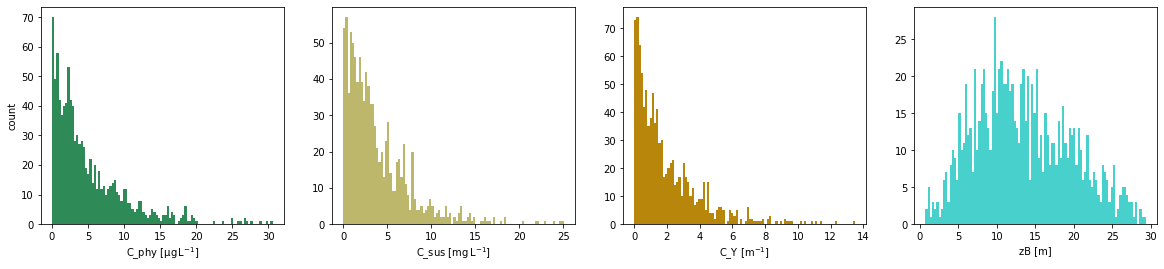

In [5]:
# Create a list of param settings that are randomly chosen from predefined distributions.
# Number of spectra to simulate
n = 1000

# Model distributions for concentrations of phytoplankton, suspended particulate matter, cdom and depth.
C_phy = np.random.gamma(1, 5, n) # to be split into C_1..C_5
C_sus = np.random.gamma(1, 4, n) # to be split into C_X, C_Mie
C_Y = np.random.gamma(1, 2, n)
zB = np.random.triangular(0.5, 10, 30, n)

# Plot distributions.
fig, axs = plt.subplots(1,4,figsize=(20,4), facecolor='white')

axs[0].hist(C_phy, bins=100, color='seagreen')
axs[0].set_xlabel('C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].set_ylabel('count')

axs[1].hist(C_sus, bins=100, color='darkkhaki')
axs[1].set_xlabel('C_sus [$\mathrm{mg \/ L^{-1}}$]')

axs[2].hist(C_Y, bins=100, color='darkgoldenrod')
axs[2].set_xlabel('C_Y [$\mathrm{m^{-1}}$]')

axs[3].hist(zB, bins=100, color='mediumturquoise')
axs[3].set_xlabel('zB [m]')

plt.show()

## Run model in forward mode

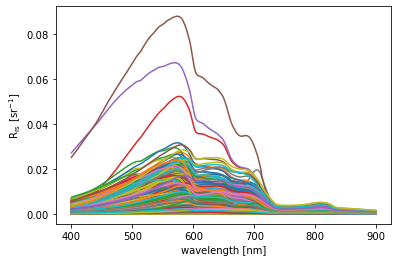

In [6]:
# Empty arrays to fill with parameters and corresponding spectra
param_arr = np.zeros((n, 15))
R_rs_arr = np.zeros((n, len(wavelengths)))

for i in np.arange(n):
    
    # C_phy[i] is randomly split up into single C_1..C_5 values that sum up to C_phy_total[i], these can be distributed over the different C_i classes.
    # We multiply C_i which is a float between 0 and 1 by 10,000 to get a reasonable large integer number, then split it up and
    # divide by 10,000 again to transform the split values back to float.
    C_1, C_2, C_3, C_4, C_5 = spectral_mixture.constrained_sum_sample_pos(n=5, total=np.int32(np.round(C_phy[i]*100000))) / 100000
    # C_sus[i] is randomly split up into single C_X and C_Mie values that sum up to C_sus_total[i].
    C_X, C_Mie = spectral_mixture.constrained_sum_sample_pos(n=2, total=np.int32(np.round(C_sus[i]*100000))) / 100000
    # Randomly split up bottom into five 6 fractions.
    f_0, f_1, f_2, f_3, f_4, f_5 = spectral_mixture.constrained_sum_sample_pos(n=6, total=np.int32(np.round(1*100000))) / 100000
    
    # Collect parameters for iths iteration.
    param_arr[i,:] = [C_1, C_2, C_3, C_4, C_5, C_X, C_Mie, C_Y[i], f_0, f_1, f_2, f_3, f_4, f_5, zB[i]]
    
    # Change parameters object accordingly.
    params.add('zB', value=zB[i])
    params.add('C_0', value=np.sum([C_1, C_2, C_3, C_4, C_5]))
    params.add('C_1', value=0)
    params.add('C_2', value=0)
    params.add('C_3', value=0)
    params.add('C_4', value=0)
    params.add('C_5', value=0)
    params.add('C_Y', value=C_Y[i])
    params.add('C_X', value=C_sus[i])
    params.add('C_Mie', value=0)
    params.add('f_0', value=f_0)
    params.add('f_1', value=f_1)
    params.add('f_2', value=f_2)
    params.add('f_3', value=f_3)
    params.add('f_4', value=f_4)
    params.add('f_5', value=f_4)
    params.add('fit_surface', value=False)
    
    # Run model in forward mode to simulate water spectra using the pre-defined parameters.
    R_rs_arr[i] = model.forward(parameters = params, 
                                wavelengths = wavelengths,
                                a_i_spec_res = a_i_spec_res,
                                a_w_res = a_w_res,
                                b_phy_norm_res = b_phy_norm_res,
                                b_bw_res = b_bw_res,
                                R_i_b_res = R_i_b_res,
                                da_W_div_dT_res = da_W_div_dT_res,
                                n2_res = n2_res)

# Compute a pseudo true-color hex code represenation for each spectrum.
colors = np.array([plotting.spectrum_to_hex(x, wavelengths) for x in R_rs_arr])

# Plot simulated spectra.
plt.plot(wavelengths, R_rs_arr.T)
plt.xlabel("wavelength [nm]")
plt.ylabel("$\mathrm{{R}_{rs}\ [sr^{-1}]}$")
plt.show()

# Testing

Now we can run the different algorithms on the simulated data set.

## Optical Water Types

### Apparent Visible Wavelength (AVW)

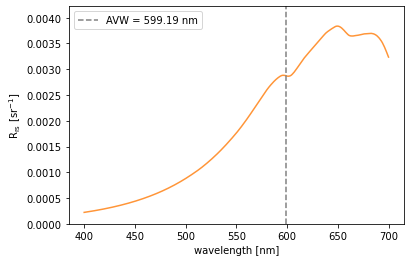

In [7]:
i = 123
selected_spectrum = R_rs_arr[i]

plt.plot(wavelengths[wavelengths<=700], selected_spectrum[wavelengths<=700], c=colors[i])
plt.vlines(ymin=0,ymax=selected_spectrum.max()+selected_spectrum.max()+0.1, x=np.round(owt.avw(selected_spectrum, wavelengths)), colors='grey', linestyle='dashed', label="AVW = "+str(np.round(owt.avw(selected_spectrum, wavelengths),2))+" nm")
plt.ylim(ymin=0,ymax=selected_spectrum.max()+selected_spectrum.max()*0.1)
plt.legend()
plt.xlabel("wavelength [nm]")
plt.ylabel("$\mathrm{{R}_{rs}\ [sr^{-1}]}$")
plt.show()

### Quality Water Index Polynomial (QWIP)

In [8]:
avw = np.array([owt.avw(x, wavelengths) for x in R_rs_arr])
ndi = np.array([indices.ndi(x[wavelengths==665],x[wavelengths==492]) for x in R_rs_arr])

qwip = np.array([owt.qwip(x) for x in avw])
qwip_interp = interp1d(np.sort(avw), qwip[np.argsort(avw)], kind="quadratic", fill_value='extrapolate')

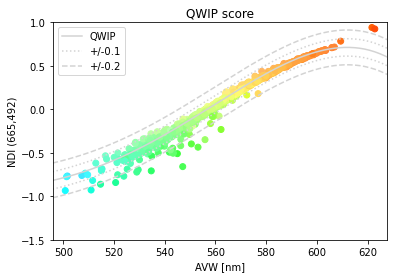

In [9]:
xrange = np.arange(avw.min()-np.abs(avw.min()*0.01), avw.max()+np.abs(avw.min()*0.01), 1)

plt.scatter(avw, ndi, c=colors)
plt.plot(xrange, qwip_interp(xrange), c="lightgrey", label="QWIP")
plt.plot(xrange, qwip_interp(xrange)+0.1,":", c="lightgrey", label="+/-0.1")
plt.plot(xrange, qwip_interp(xrange)-0.1,":", c="lightgrey")
plt.plot(xrange, qwip_interp(xrange)+0.2,"--", c="lightgrey", label="+/-0.2")
plt.plot(xrange, qwip_interp(xrange)-0.2,"--", c="lightgrey")
plt.legend()
plt.xlim(xrange.min(), xrange.max())
plt.ylim(-1.5,1)
plt.xlabel('AVW [nm]')
plt.ylabel('NDI (665,492)')
plt.title('QWIP score')
plt.show()

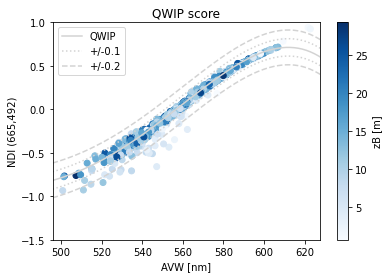

In [10]:
xrange = np.arange(avw.min()-np.abs(avw.min()*0.01), avw.max()+np.abs(avw.min()*0.01), 1)

plt.scatter(avw, ndi, c=zB, cmap='Blues')
plt.plot(xrange, qwip_interp(xrange), c="lightgrey", label="QWIP")
plt.plot(xrange, qwip_interp(xrange)+0.1,":", c="lightgrey", label="+/-0.1")
plt.plot(xrange, qwip_interp(xrange)-0.1,":", c="lightgrey")
plt.plot(xrange, qwip_interp(xrange)+0.2,"--", c="lightgrey", label="+/-0.2")
plt.plot(xrange, qwip_interp(xrange)-0.2,"--", c="lightgrey")
plt.legend()
plt.xlim(xrange.min(), xrange.max())
plt.ylim(-1.5,1)
plt.xlabel('AVW [nm]')
plt.ylabel('NDI (665,492)')
plt.title('QWIP score')
plt.colorbar(label='zB [m]')
plt.show()

### OWT following Balasubramanian et al. (2020)

In [11]:
bala = np.array([owt.balasubramanian(x, wavelengths) for x in R_rs_arr])

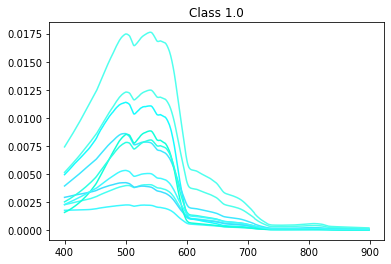

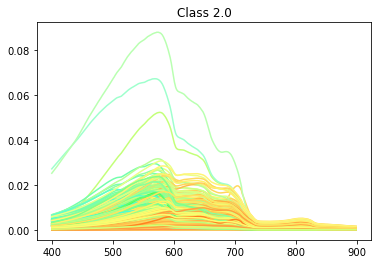

In [12]:
for c in np.unique(bala):
    for i in np.arange(R_rs_arr[bala==c].shape[0]):
        plt.plot(wavelengths, R_rs_arr[bala==c][i],
                 color = colors[bala==c][i])
        plt.title("Class "+str(c))
    plt.show()

### OWT following Jiang et al. (2021)

In [13]:
ji = np.array([owt.jiang(x, wavelengths) for x in R_rs_arr])

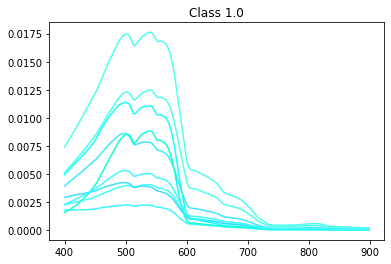

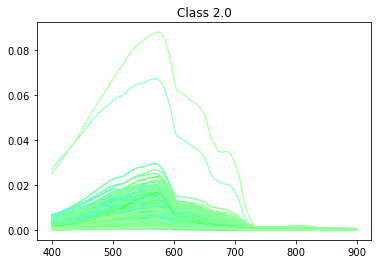

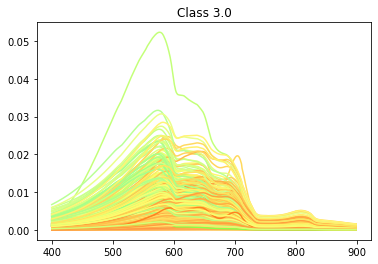

In [14]:
for c in np.unique(ji):
    for i in np.arange(R_rs_arr[ji==c].shape[0]):
        plt.plot(wavelengths, R_rs_arr[ji==c][i],
                 color = colors[ji==c][i])
        plt.title("Class "+str(c))
    plt.show()

### Forel-Ule Scale

In [15]:
fu, dwl = np.array([owt.forel_ule(x, wavelengths) for x in R_rs_arr]).T

In [16]:
fuc = pd.read_csv(('\\').join(os.path.abspath(bio_optics.__file__).split('\\')[:-1]+['data\\fu_scale.txt']), skiprows=7)
plotcolor = fuc.plotcolor[fu-1].values

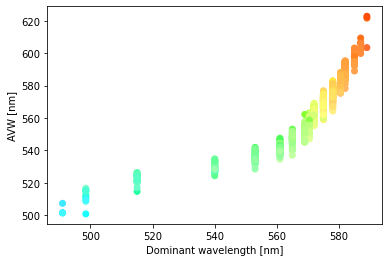

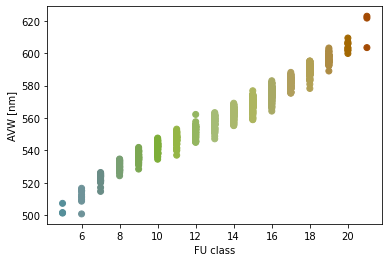

In [17]:
# plt.figure(figsize=(15,7))
plt.scatter(dwl, avw, c=colors)
plt.xlabel('Dominant wavelength [nm]')
plt.ylabel('AVW [nm]')
plt.show()

# plt.figure(figsize=(15,7))
plt.scatter(fu, avw, c=plotcolor)
plt.xlabel('FU class')
plt.ylabel('AVW [nm]')
plt.show()

## Turbidity

For simplicity we assume that turbidity is highly correlated with the concentration of suspended scattering particles (C_X + C_Mie).

In [18]:
simulated_turbidity = param_arr[:, 5:7].sum(axis=1)

### Dogliotti et al. (2015)

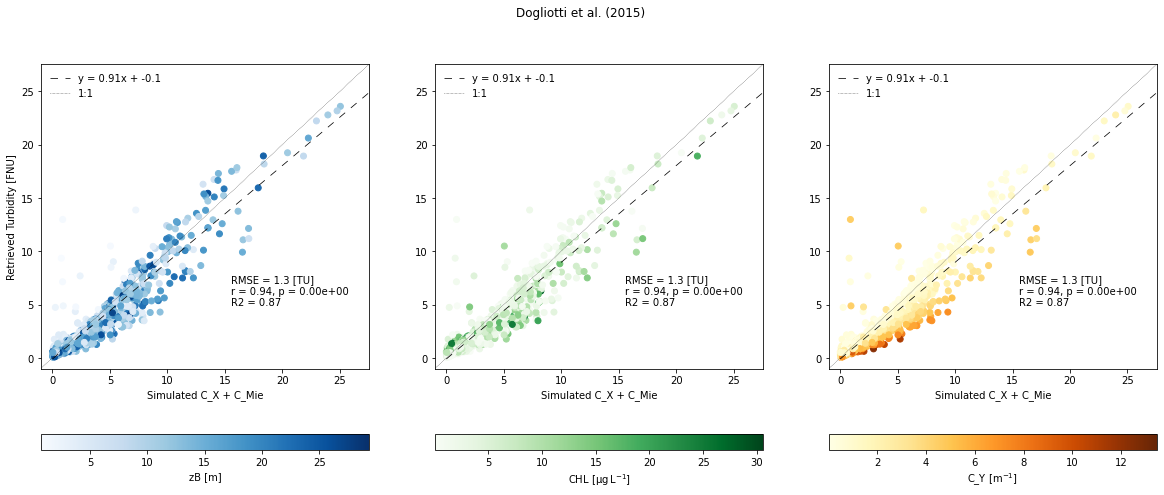

In [19]:
y_true = simulated_turbidity
y_pred = np.array([turbidity.dogliotti(x*np.pi, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [TU]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')

axs[0].set_xlim(-1,np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-1,np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Retrieved Turbidity [FNU]')
axs[0].set_xlabel('Simulated C_X + C_Mie')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_phy, cmap='Greens')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [TU]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')

axs[1].set_xlim(-1,np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-1,np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_X + C_Mie')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [TU]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')

axs[2].set_xlim(-1,np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-1,np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_X + C_Mie')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='CHL [$\mathrm{\mu g \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("Dogliotti et al. (2015)")

plt.show()

### HICO / Keith et al. (2014)

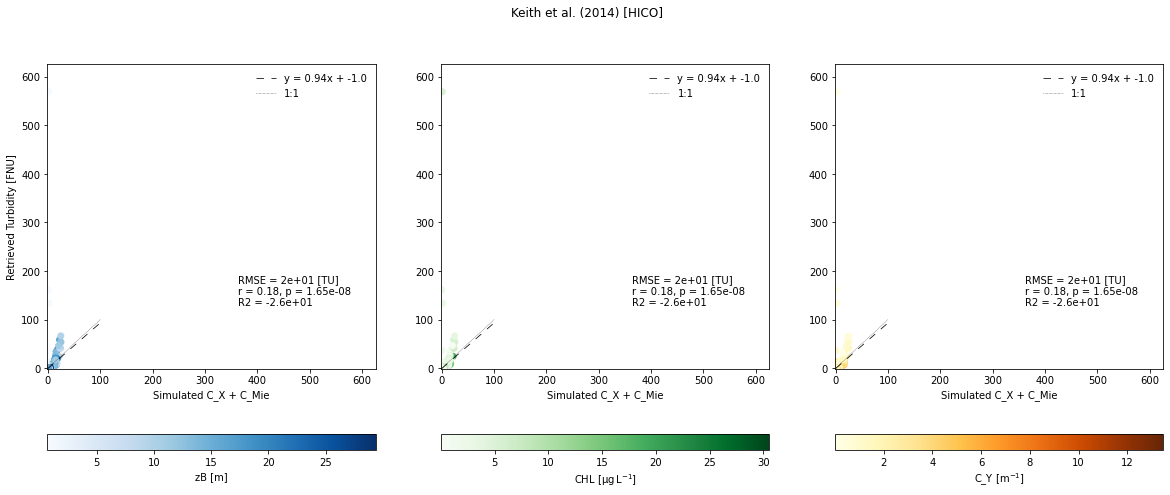

In [20]:
y_true = simulated_turbidity
y_pred = np.array([turbidity.hico(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [TU]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Retrieved Turbidity [FNU]')
axs[0].set_xlabel('Simulated C_X + C_Mie')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_phy, cmap='Greens')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [TU]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_X + C_Mie')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [TU]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-1,np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-1,np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_X + C_Mie')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='CHL [$\mathrm{\mu g \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("Keith et al. (2014) [HICO]")

plt.show()

### Petus et al. (2010)

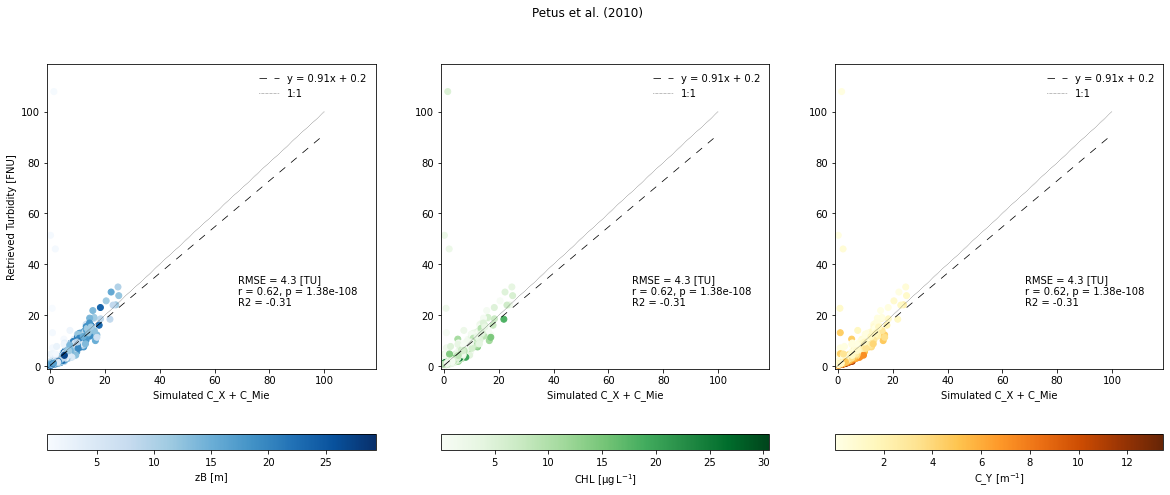

In [21]:
fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')

##################################
#### LEFT PANEL: MEAN +/- STD ####

y_true = simulated_turbidity
y_pred = np.array([turbidity.petus(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [TU]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Retrieved Turbidity [FNU]')
axs[0].set_xlabel('Simulated C_X + C_Mie')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_phy, cmap='Greens')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [TU]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_X + C_Mie')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [TU]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_X + C_Mie')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='CHL [$\mathrm{\mu g \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("Petus et al. (2010)")

plt.show()

### Potes et al. (2010)

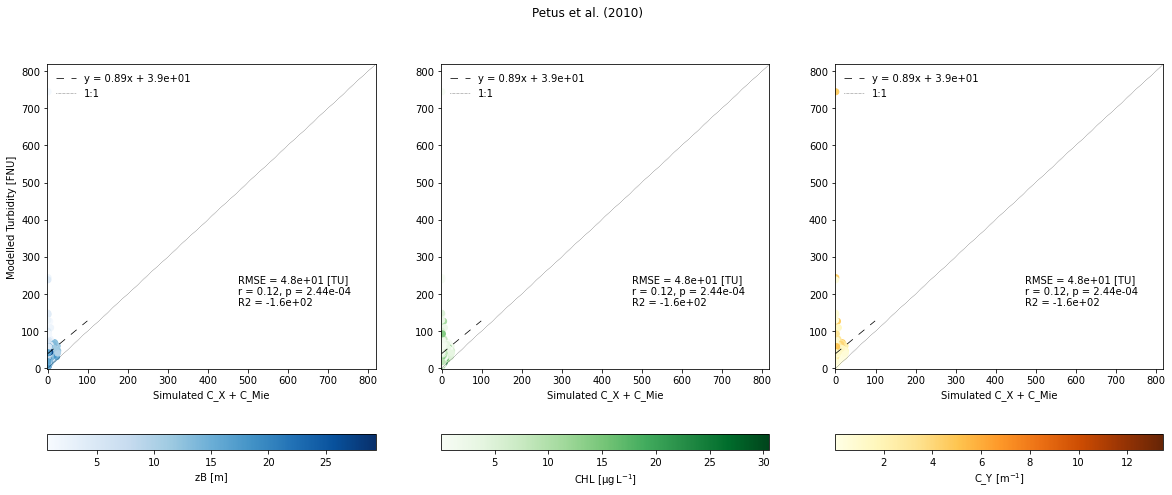

In [22]:
y_true = simulated_turbidity
y_pred = np.array([turbidity.potes(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,1000],[-10,1000], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [TU]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled Turbidity [FNU]')
axs[0].set_xlabel('Simulated C_X + C_Mie')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_phy, cmap='Greens')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,1000],[-10,1000], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [TU]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_X + C_Mie')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,1000],[-10,1000], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [TU]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_X + C_Mie')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='CHL [$\mathrm{\mu g \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("Petus et al. (2010)")

plt.show()

### Chen et al. (2007)

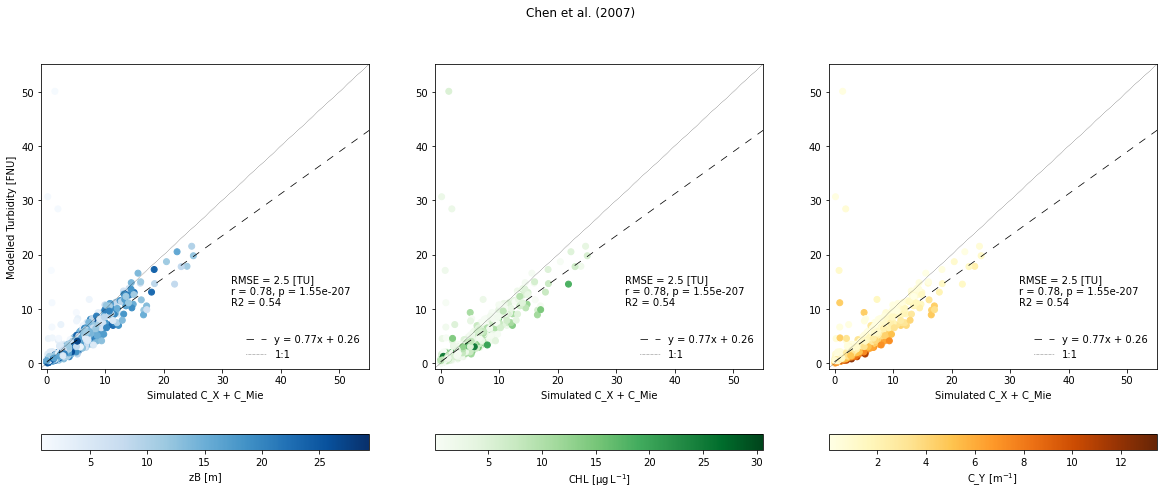

In [23]:
y_true = simulated_turbidity
y_pred = np.array([turbidity.chen(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [TU]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')

axs[0].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled Turbidity [FNU]')
axs[0].set_xlabel('Simulated C_X + C_Mie')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_phy, cmap='Greens')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [TU]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')

axs[1].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_X + C_Mie')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [TU]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')

axs[2].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_X + C_Mie')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='CHL [$\mathrm{\mu g \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("Chen et al. (2007)")

plt.show()

## SPM

In [24]:
simulated_spm = param_arr[:, :5].sum(axis=1)/1000 + param_arr[:, 5:7].sum(axis=1)

### Jiang et al. (2021)

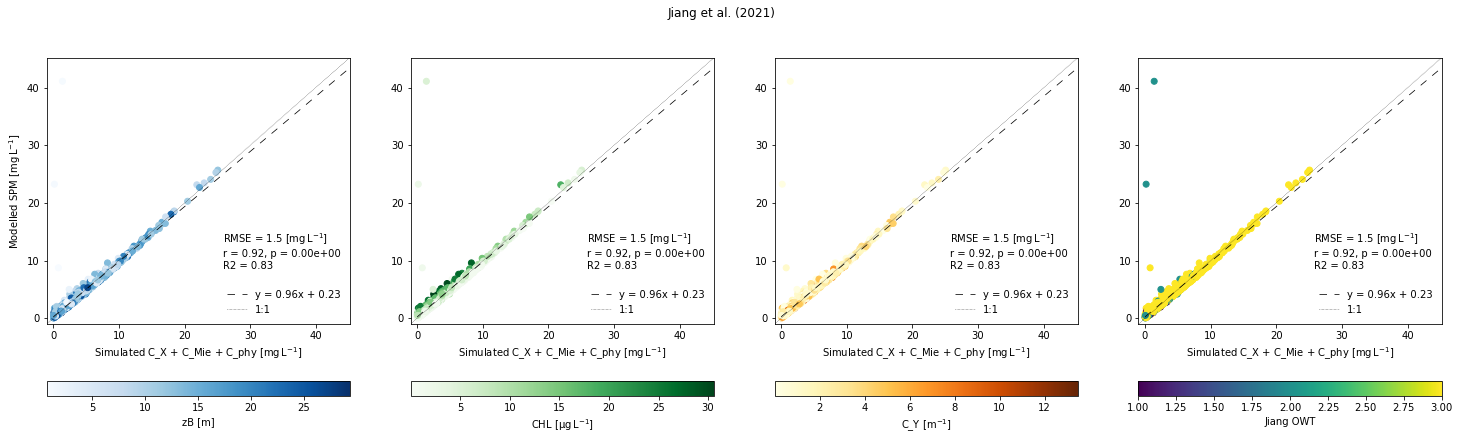

In [25]:
y_true = simulated_spm
y_pred = np.array([spm.jiang(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,4,figsize=(25,7), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{mg \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled SPM [$\mathrm{mg \/ L^{-1}}$]')
axs[0].set_xlabel('Simulated C_X + C_Mie + C_phy [$\mathrm{mg \/ L^{-1}}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_phy, cmap='Greens')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{mg \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_X + C_Mie + C_phy [$\mathrm{mg \/ L^{-1}}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{mg \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_X + C_Mie + C_phy [$\mathrm{mg \/ L^{-1}}$]')
axs[2].legend(frameon=False)
##################################

im3 = axs[3].scatter(y_true, y_pred, c=ji)
# line of best fit
axs[3].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[3].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')

axs[3].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{mg \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')

axs[3].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[3].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[3].set_xlabel('Simulated C_X + C_Mie + C_phy [$\mathrm{mg \/ L^{-1}}$]')
axs[3].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='CHL [$\mathrm{\mu g \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.colorbar(im3, ax=axs[3], orientation='horizontal', label='Jiang OWT')
fig.suptitle("Jiang et al. (2021)")

plt.show()

### D'Sa et al. (2007)

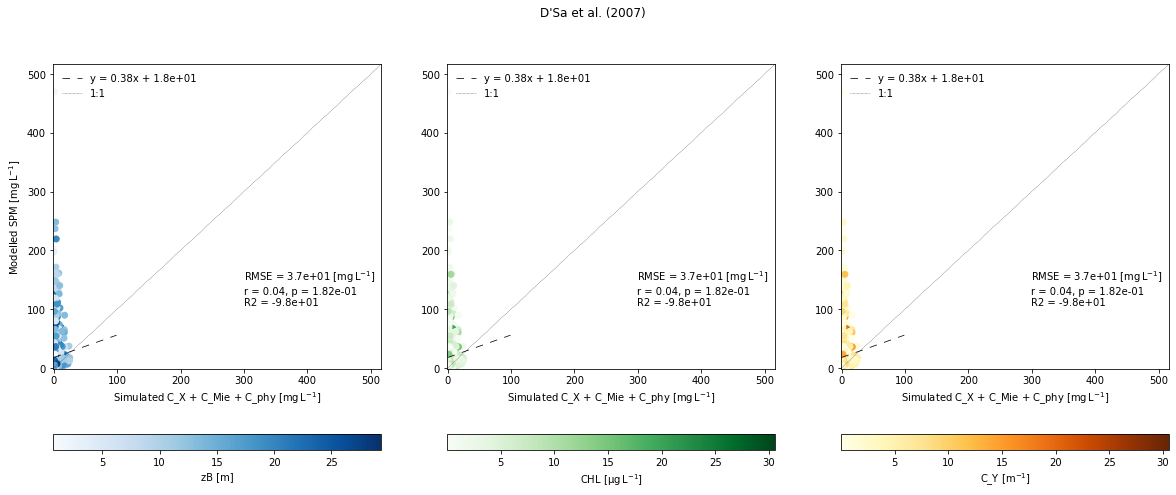

In [26]:
y_true = simulated_spm
y_pred = np.array([spm.dsa(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,1000],[-10,1000], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{mg \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled SPM [$\mathrm{mg \/ L^{-1}}$]')
axs[0].set_xlabel('Simulated C_X + C_Mie + C_phy [$\mathrm{mg \/ L^{-1}}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_phy, cmap='Greens')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,1000],[-10,1000], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{mg \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_X + C_Mie + C_phy [$\mathrm{mg \/ L^{-1}}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_phy, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,1000],[-10,1000], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{mg \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_X + C_Mie + C_phy [$\mathrm{mg \/ L^{-1}}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='CHL [$\mathrm{\mu g \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("D'Sa et al. (2007)")

plt.show()

### Petus et al. (2010)

Text(0.5, 0.98, 'Petus et al. (2010)')

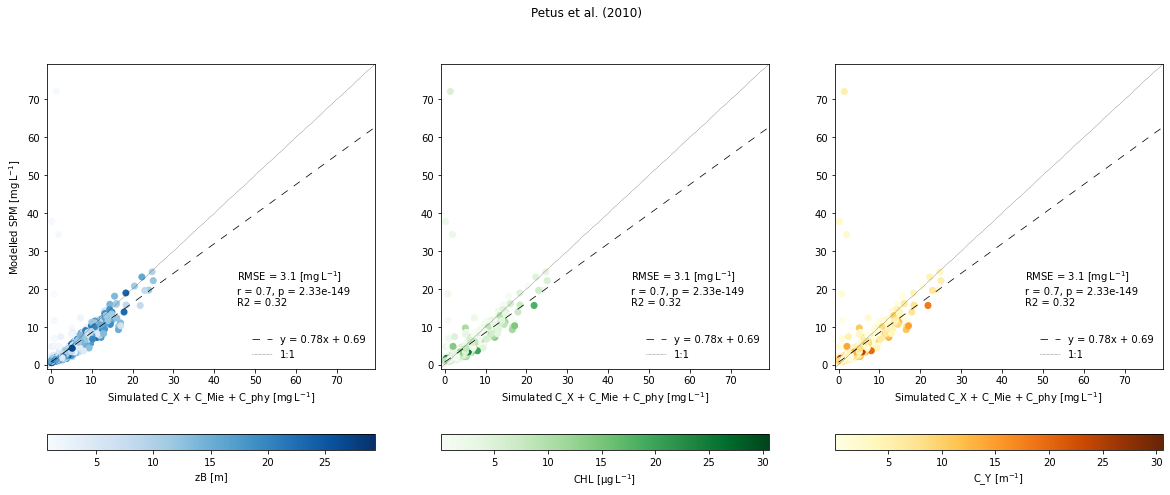

In [27]:
y_true = simulated_spm
y_pred = np.array([spm.petus(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{mg \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled SPM [$\mathrm{mg \/ L^{-1}}$]')
axs[0].set_xlabel('Simulated C_X + C_Mie + C_phy [$\mathrm{mg \/ L^{-1}}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_phy, cmap='Greens')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{mg \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_X + C_Mie + C_phy [$\mathrm{mg \/ L^{-1}}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_phy, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{mg \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_X + C_Mie + C_phy [$\mathrm{mg \/ L^{-1}}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='CHL [$\mathrm{\mu g \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')

fig.suptitle("Petus et al. (2010)")

### Miller et al. (2004)

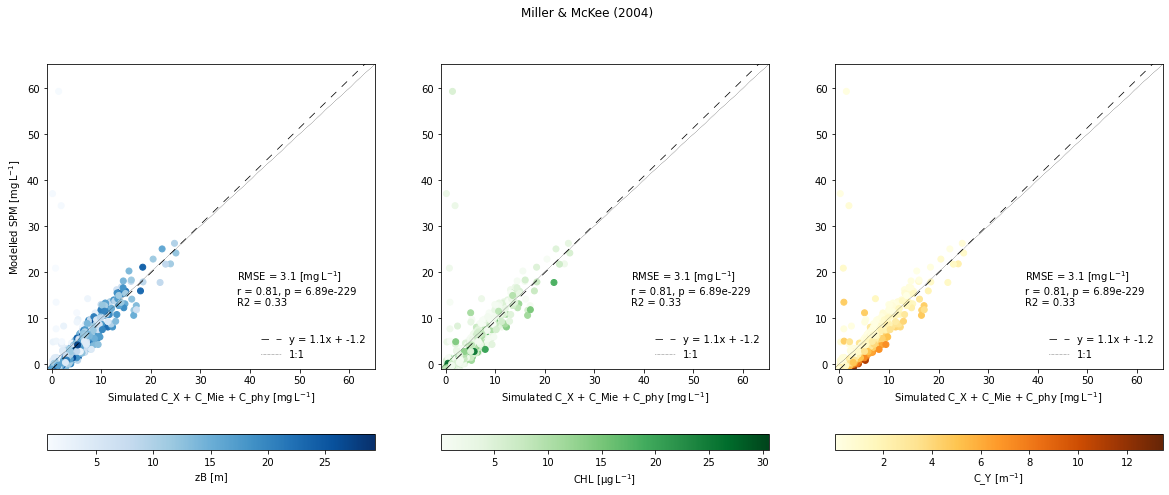

In [28]:
y_true = simulated_spm
y_pred = np.array([spm.miller(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{mg \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled SPM [$\mathrm{mg \/ L^{-1}}$]')
axs[0].set_xlabel('Simulated C_X + C_Mie + C_phy [$\mathrm{mg \/ L^{-1}}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_phy, cmap='Greens')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{mg \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_X + C_Mie + C_phy [$\mathrm{mg \/ L^{-1}}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{mg \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_X + C_Mie + C_phy [$\mathrm{mg \/ L^{-1}}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='CHL [$\mathrm{\mu g \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("Miller & McKee (2004)")

plt.show()

### Novoa et al. (2017)

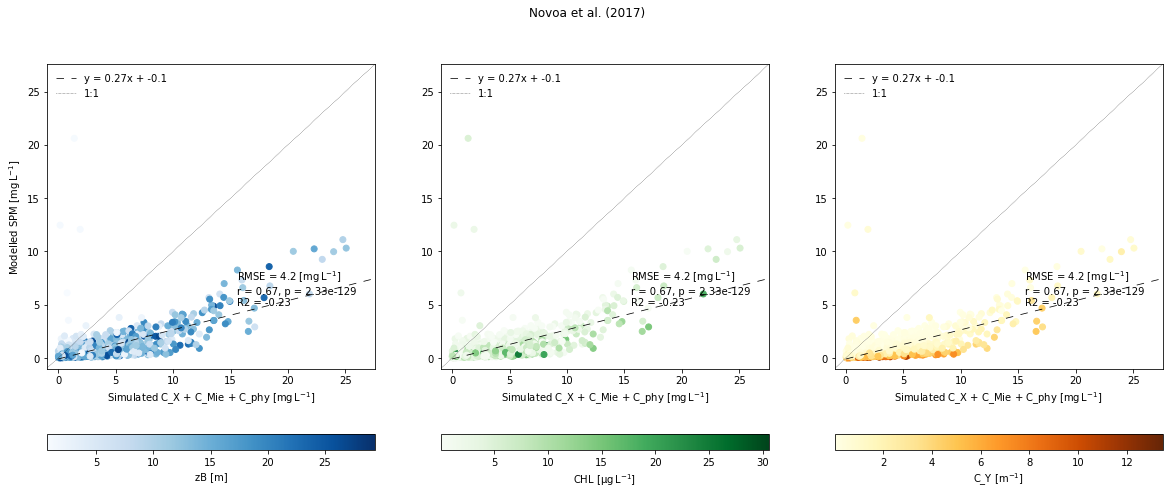

In [29]:
y_true = simulated_spm
y_pred = np.array([spm.novoa(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{mg \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled SPM [$\mathrm{mg \/ L^{-1}}$]')
axs[0].set_xlabel('Simulated C_X + C_Mie + C_phy [$\mathrm{mg \/ L^{-1}}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_phy, cmap='Greens')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{mg \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_X + C_Mie + C_phy [$\mathrm{mg \/ L^{-1}}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{mg \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_X + C_Mie + C_phy [$\mathrm{mg \/ L^{-1}}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='CHL [$\mathrm{\mu g \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("Novoa et al. (2017)")

plt.show()

### GAA / Yu et al. (2019)

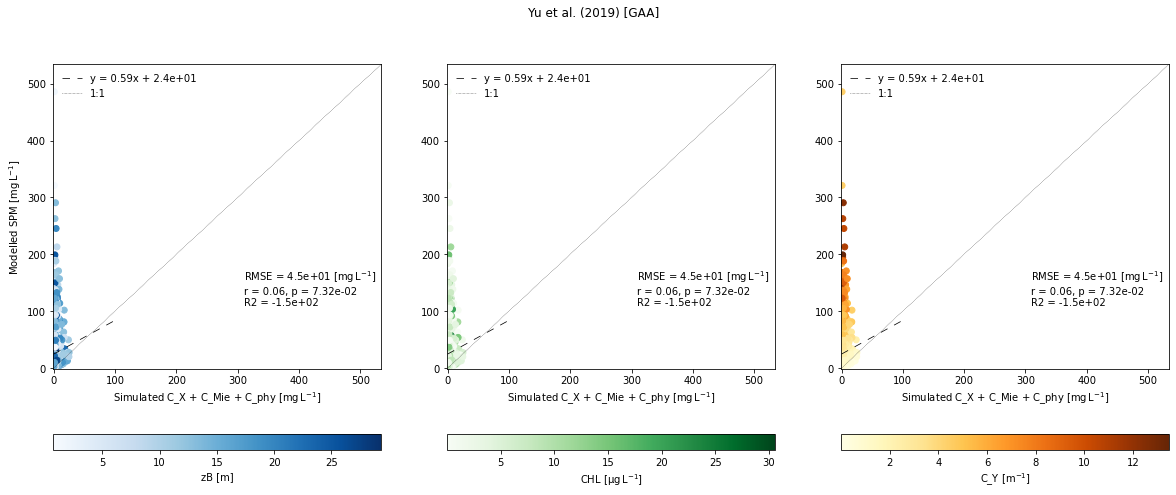

In [30]:
y_true = simulated_spm
y_pred = np.array([spm.gaa(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,1000],[-10,1000], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{mg \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled SPM [$\mathrm{mg \/ L^{-1}}$]')
axs[0].set_xlabel('Simulated C_X + C_Mie + C_phy [$\mathrm{mg \/ L^{-1}}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_phy, cmap='Greens')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,1000],[-10,1000], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{mg \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_X + C_Mie + C_phy [$\mathrm{mg \/ L^{-1}}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,1000],[-10,1000], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{mg \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_X + C_Mie + C_phy [$\mathrm{mg \/ L^{-1}}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='CHL [$\mathrm{\mu g \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("Yu et al. (2019) [GAA]")

plt.show()

## Chlorophyll

In [31]:
simulated_chl = param_arr[:, :5].sum(axis=1)

### HICO / Keith et al. (2014)

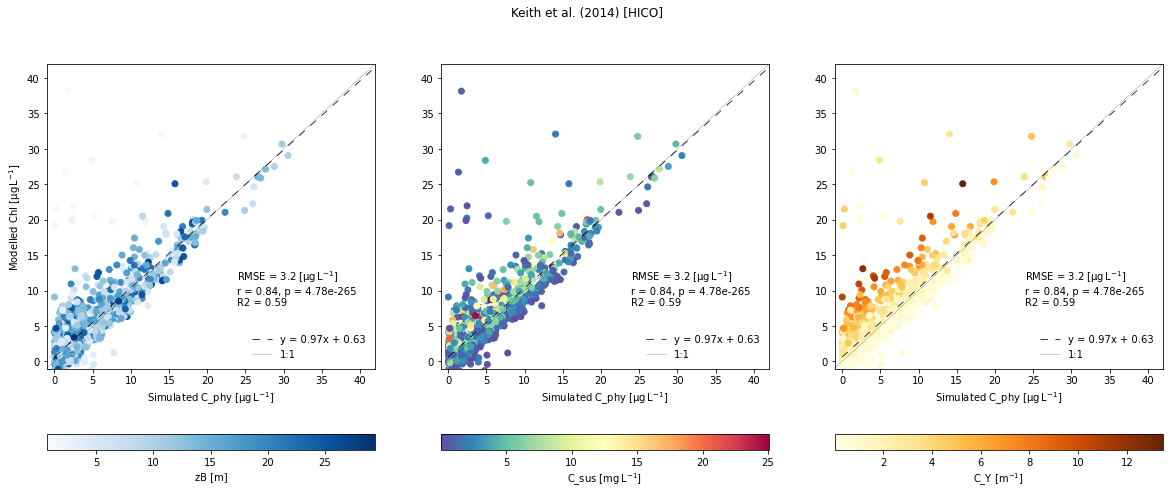

In [32]:
y_true = simulated_chl
y_pred = np.array([chl.hico(x, wavelengths) for x in R_rs_arr]) * 20 - 100 ## !!!
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled Chl [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_sus, cmap='Spectral_r')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='C_sus [$\mathrm{mg \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("Keith et al. (2014) [HICO]")

plt.show()

### Gitelson et al. (2008)

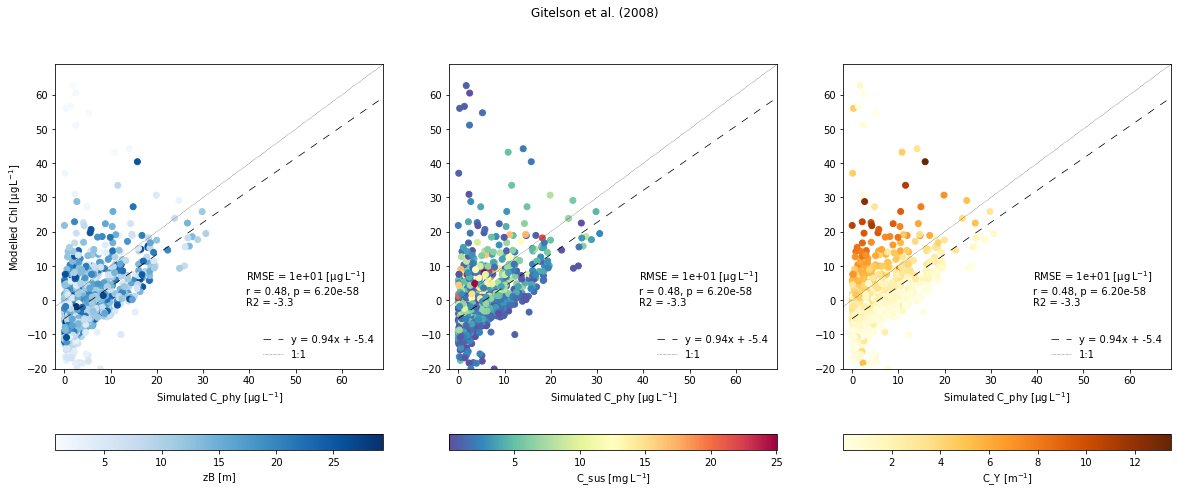

In [33]:
y_true = simulated_chl
y_pred = np.array([chl.gitelson(x, wavelengths) for x in R_rs_arr]) * 3 - 4.4 ## !!!
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled Chl [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_sus, cmap='Spectral_r')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='C_sus [$\mathrm{mg \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("Gitelson et al. (2008)")

plt.show()

### Fluorescence Line Height (FLH)

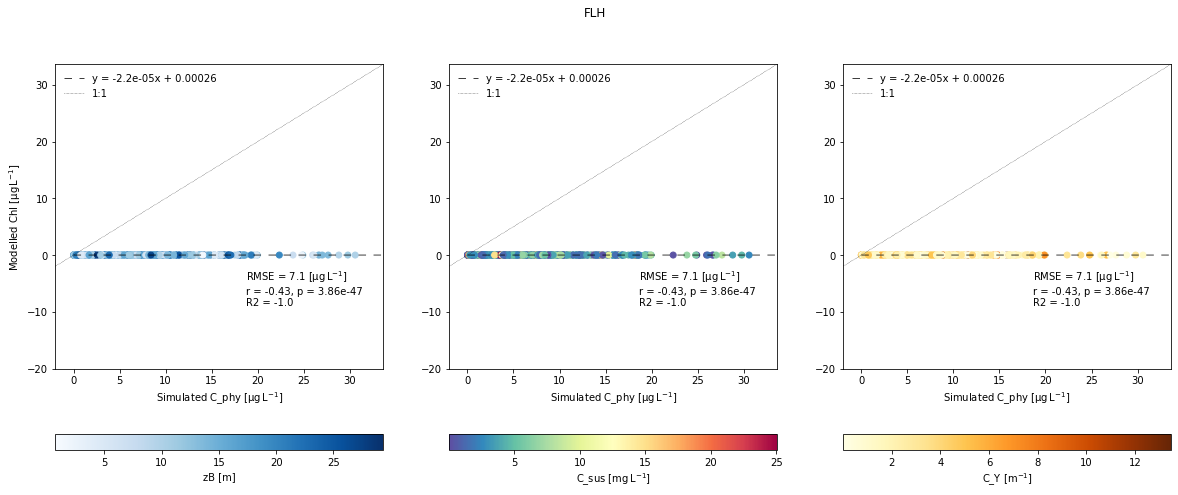

In [34]:
y_true = simulated_chl
y_pred = np.array([chl.flh(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled Chl [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_sus, cmap='Spectral_r')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='C_sus [$\mathrm{mg \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("FLH")

plt.show()

### OC4Me / Mishra et al. (2017)

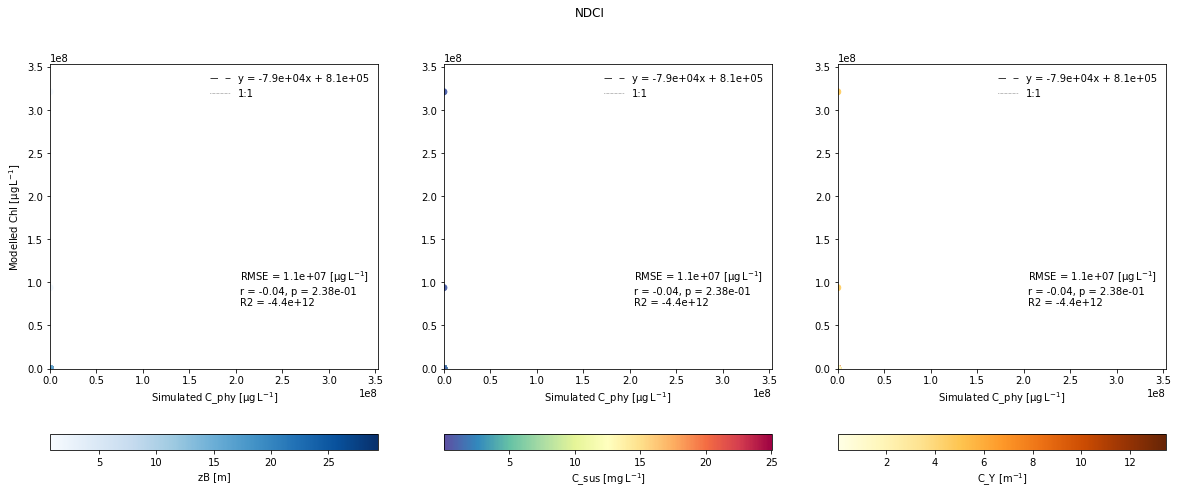

In [35]:
y_true = simulated_chl
y_pred = np.array([chl.oc4me(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled Chl [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_sus, cmap='Spectral_r')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='C_sus [$\mathrm{mg \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("NDCI")

plt.show()

### Potes et al. (2018)

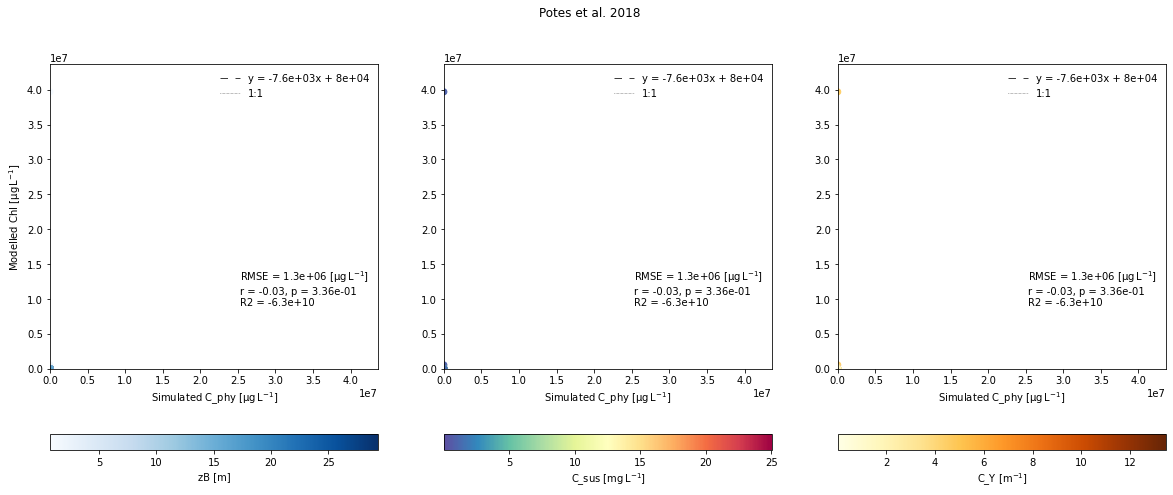

In [36]:
y_true = simulated_chl
y_pred = np.array([chl.potes_chl(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled Chl [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_sus, cmap='Spectral_r')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='C_sus [$\mathrm{mg \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("Potes et al. 2018")

plt.show()

### Normalized Difference Chlorophyll Index (NDCI)

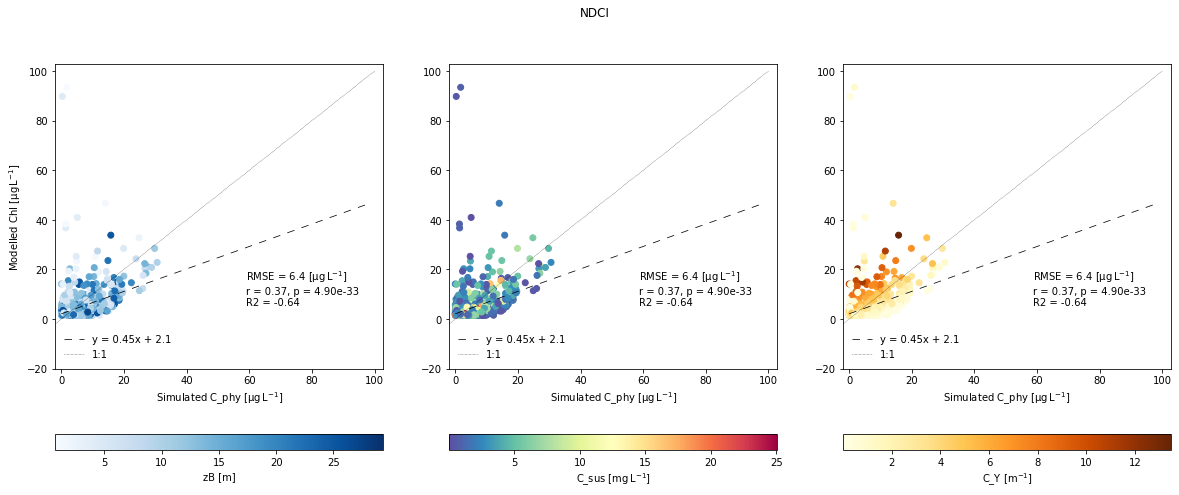

In [37]:
y_true = simulated_chl
y_pred = np.array([chl.ndci(x, wavelengths) for x in R_rs_arr]) * 3-12 ## !!!
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled Chl [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_sus, cmap='Spectral_r')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='C_sus [$\mathrm{mg \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("NDCI")

plt.show()

### Li et al. (2019)

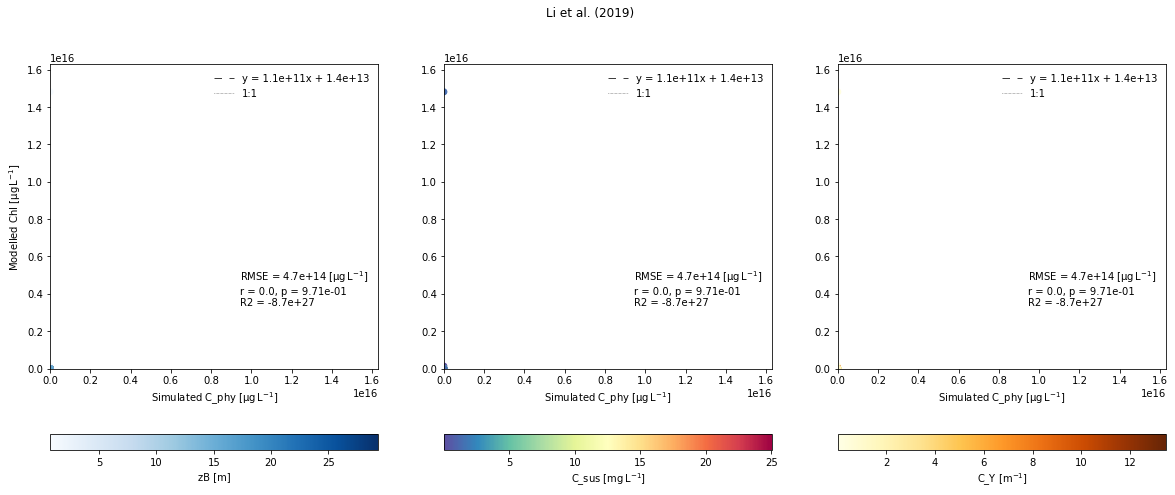

In [38]:
y_true = simulated_chl
y_pred = np.array([chl.li(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled Chl [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_sus, cmap='Spectral_r')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='C_sus [$\mathrm{mg \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("Li et al. (2019)")

plt.show()

### GUC2 / Menon & Adhikari (2018)

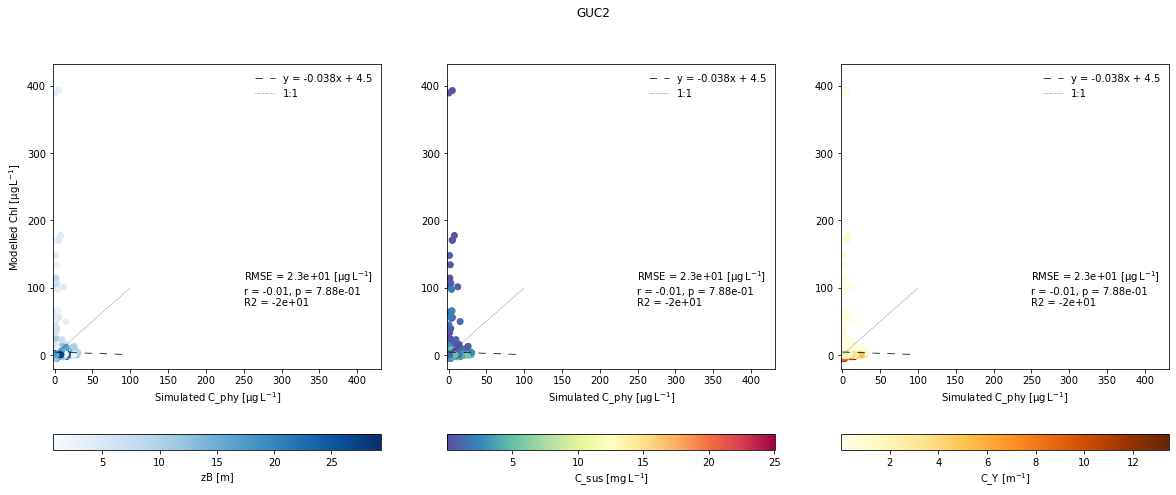

In [39]:
y_true = simulated_chl
y_pred = np.array([chl.guc2(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled Chl [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_sus, cmap='Spectral_r')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='C_sus [$\mathrm{mg \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("GUC2")

plt.show()

### 2-band algorithm described in Neil et al. (2018)

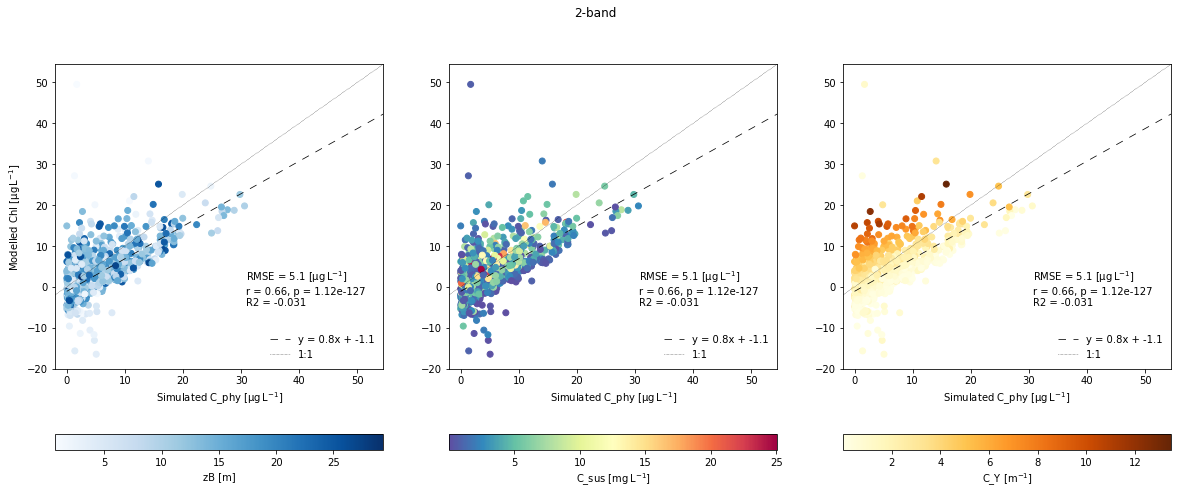

In [40]:
y_true = simulated_chl
y_pred = np.array([chl.two_band(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled Chl [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_sus, cmap='Spectral_r')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='C_sus [$\mathrm{mg \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("2-band")

plt.show()

### 3-band after Moses et al. (2009)

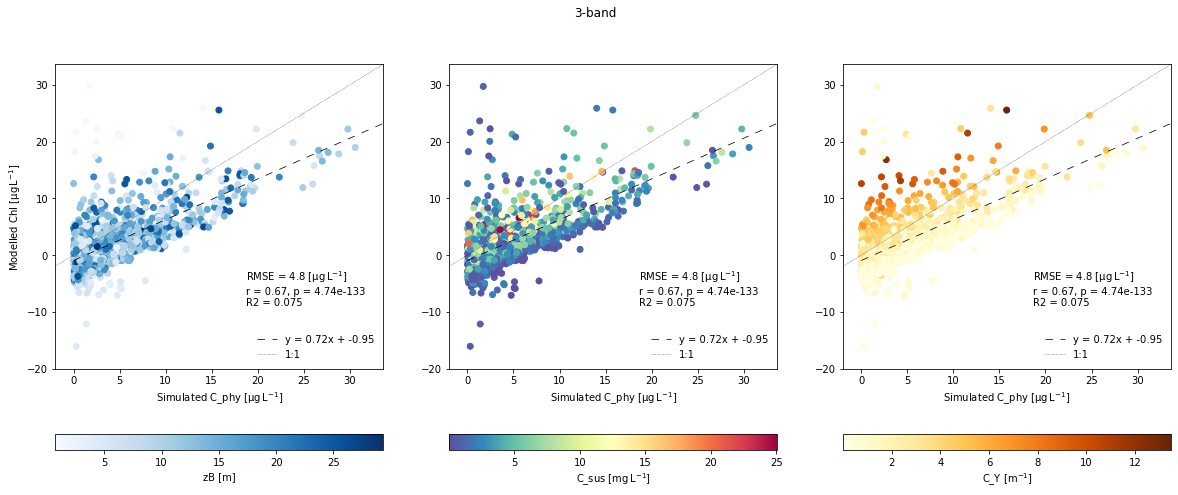

In [41]:
y_true = simulated_chl
y_pred = np.array([chl.three_band(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled Chl [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_sus, cmap='Spectral_r')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='C_sus [$\mathrm{mg \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("3-band")

plt.show()

### Gurlin

#### 2-band algorithm after Gurlin et al. (2011)

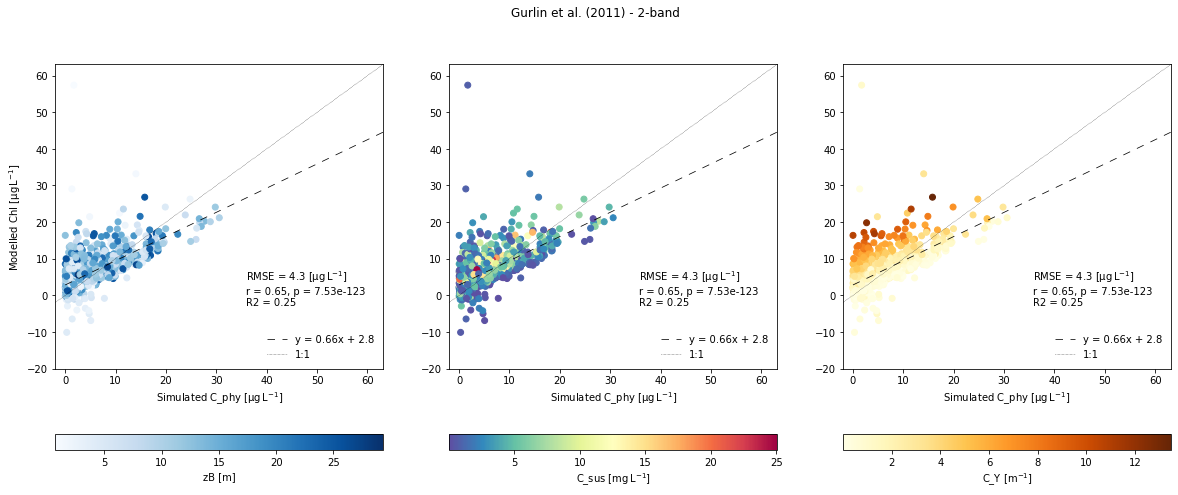

In [42]:
y_true = simulated_chl
y_pred = np.array([chl.gurlin_two_band(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled Chl [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_sus, cmap='Spectral_r')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='C_sus [$\mathrm{mg \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("Gurlin et al. (2011) - 2-band")

plt.show()

#### 3-band

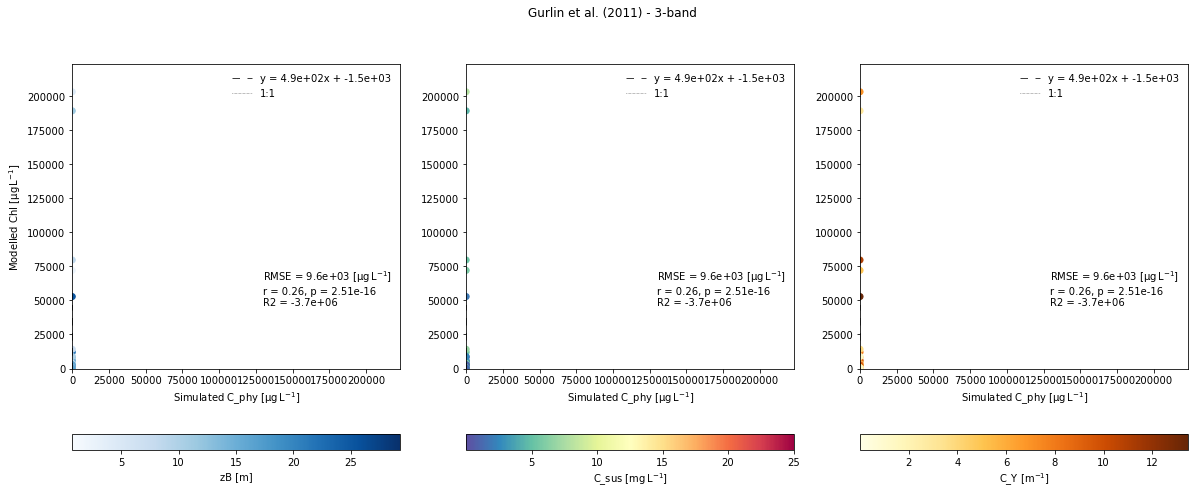

In [43]:
y_true = simulated_chl
y_pred = np.array([chl.gurlin_three_band(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled Chl [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_sus, cmap='Spectral_r')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='C_sus [$\mathrm{mg \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
fig.suptitle("Gurlin et al. (2011) - 3-band")

plt.show()

### Analytical 2-band

In [44]:
# fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')

# ##################################
# #### LEFT PANEL: MEAN +/- STD ####

# y_true = simulated_chl
# y_pred = np.array([chl.analytical_two_band(x, wavelengths) for x in R_rs_arr])
                      
# rmse = np.sqrt(mean_squared_error(y_true, y_pred))
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
# r2 = r2_score(y_true, y_pred)
# ##################################

# im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# # line of best fit
# axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# # 1:1 line 
# axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')

# axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
#              'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
#              'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
#              xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')

# axs[0].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
# axs[0].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
# axs[0].set_ylabel('Modelled Chl [$\mathrm{\mu g \/ L^{-1}}$]')
# axs[0].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
# axs[0].legend(frameon=False)
# ##################################

# im1 = axs[1].scatter(y_true, y_pred, c=C_sus, cmap='Spectral_r')
# # line of best fit
# axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# # 1:1 line 
# axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')

# axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
#              'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
#              'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
#              xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')

# axs[1].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
# axs[1].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
# # axs[1].set_ylabel('Modelled Chl [$\mathrm{\mu g \/ L^{-1}}$]')
# axs[1].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
# axs[1].legend(frameon=False)
# ##################################

# im2 = axs[2].scatter(y_true, y_pred, c=C_Y, cmap='YlOrBr')
# # line of best fit
# axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# # 1:1 line 
# axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')

# axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{\mu g \/ L^{-1}}$]' + '\n' + 
#              'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
#              'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
#              xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')

# axs[2].set_xlim(-2, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
# axs[2].set_ylim(-20, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
# # axs[1].set_ylabel('Modelled Chl [$\mathrm{\mu g \/ L^{-1}}$]')
# axs[2].set_xlabel('Simulated C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
# axs[2].legend(frameon=False)
# ##################################


# fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
# fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='C_sus [$\mathrm{mg \/ L^{-1}}$]')
# fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_Y [$\mathrm{m}^{-1}$]')
# fig.suptitle("Li et al. (2019)")

## CDOM

In [45]:
simulated_cdom = param_arr[:, 7]

### HICO / Keith et al. (2014)

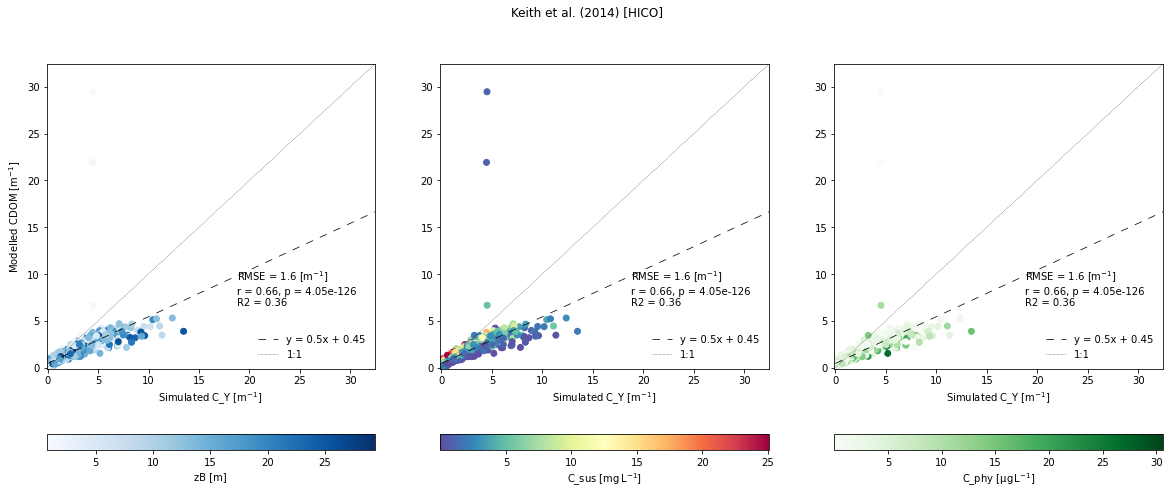

In [46]:
y_true = simulated_cdom
y_pred = np.array([cdom.hico(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{m}^{-1}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled CDOM [$\mathrm{m}^{-1}$]')
axs[0].set_xlabel('Simulated C_Y [$\mathrm{m}^{-1}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_sus, cmap='Spectral_r')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{m}^{-1}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_Y [$\mathrm{m}^{-1}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_phy, cmap='Greens')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{m}^{-1}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_Y [$\mathrm{m}^{-1}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='C_sus [$\mathrm{mg \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
fig.suptitle("Keith et al. (2014) [HICO]")

plt.show()

### Loisel

In [47]:
y_true = simulated_cdom
y_pred = np.array([cdom.loisel(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{m}^{-1}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled CDOM [$\mathrm{m}^{-1}$]')
axs[0].set_xlabel('Simulated C_Y [$\mathrm{m}^{-1}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_sus, cmap='Spectral_r')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{m}^{-1}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_Y [$\mathrm{m}^{-1}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_phy, cmap='Greens')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{m}^{-1}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_Y [$\mathrm{m}^{-1}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='C_sus [$\mathrm{mg \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
fig.suptitle("Loisel et al. (2014)")

plt.show()

c:\users\mkoenig3\dropbox (asu)\backup\documents\github\bio_optics\bio_optics\models\cdom.py:51: RuntimeWarning: invalid value encountered in log10
  a_CDOM412 = 10**(0.1548 * np.log10(X)**2 + 1.1939 * np.log10(X) + 0.0689)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Mannino

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')

##################################
#### LEFT PANEL: MEAN +/- STD ####

y_true = simulated_cdom
y_pred = np.array([cdom.mannino(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{m}^{-1}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled CDOM [$\mathrm{m}^{-1}$]')
axs[0].set_xlabel('Simulated C_Y [$\mathrm{m}^{-1}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_sus, cmap='Spectral_r')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{m}^{-1}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_Y [$\mathrm{m}^{-1}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_phy, cmap='Greens')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{m}^{-1}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_Y [$\mathrm{m}^{-1}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='C_sus [$\mathrm{mg \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
fig.suptitle("Mannino et al. (2008)")

plt.show()

NameError: name 'plt' is not defined

### Ficek et al. (2011)

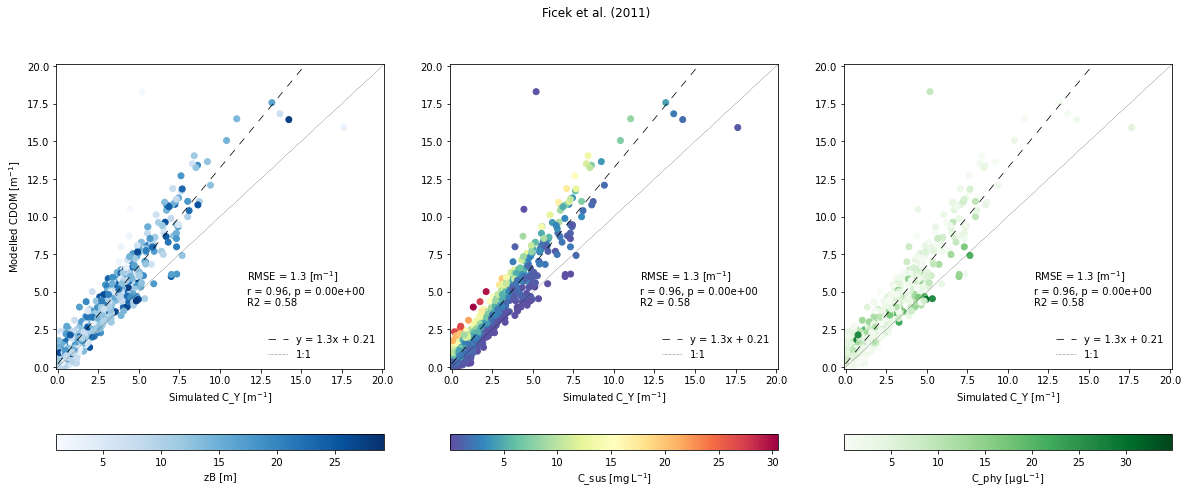

In [ ]:
y_true = simulated_cdom
y_pred = np.array([cdom.ficek(x, wavelengths) for x in R_rs_arr])
                      
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
##################################

fig, axs = plt.subplots(1,3,figsize=(20,8), facecolor='white')
##################################
im0 = axs[0].scatter(y_true, y_pred, c=zB, cmap='Blues')
# line of best fit
axs[0].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[0].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[0].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{m}^{-1}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[0].set_xlim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[0].set_ylabel('Modelled CDOM [$\mathrm{m}^{-1}$]')
axs[0].set_xlabel('Simulated C_Y [$\mathrm{m}^{-1}$]')
axs[0].legend(frameon=False)
##################################

im1 = axs[1].scatter(y_true, y_pred, c=C_sus, cmap='Spectral_r')
# line of best fit
axs[1].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[1].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[1].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{m}^{-1}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[1].set_xlim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_ylim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[1].set_xlabel('Simulated C_Y [$\mathrm{m}^{-1}$]')
axs[1].legend(frameon=False)
##################################

im2 = axs[2].scatter(y_true, y_pred, c=C_phy, cmap='Greens')
# line of best fit
axs[2].plot(intercept + slope * np.arange(0,100), '--', dashes=(10, 10), c='k', label='y = ' + '{:0.2}'.format(slope) + 'x + ' + '{:0.2}'.format(intercept), linewidth=0.75)
# 1:1 line 
axs[2].plot([-10,100],[-10,100], ':', c='k', linewidth=0.5, label='1:1')
axs[2].annotate('RMSE = '+'{:0.2}'.format(rmse) + ' [$\mathrm{m}^{-1}$]' + '\n' + 
             'r = '+str(np.round(r_value,2)) + ', p = ' + '{:0.2e}'.format(p_value) +  '\n' +
             'R2 = '+'{:0.2}'.format(r2), xy=(0.58, 0.2), 
             xycoords='axes fraction', fontsize=10, horizontalalignment='left', verticalalignment='bottom')
axs[2].set_xlim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_ylim(-0.1, np.max([y_true.max(), y_pred.max()]) + 0.1*np.max([y_true.max(), y_pred.max()]))
axs[2].set_xlabel('Simulated C_Y [$\mathrm{m}^{-1}$]')
axs[2].legend(frameon=False)
##################################

fig.colorbar(im0, ax=axs[0], orientation='horizontal', label='zB [m]')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', label='C_sus [$\mathrm{mg \/ L^{-1}}$]')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', label='C_phy [$\mathrm{\mu g \/ L^{-1}}$]')
fig.suptitle("Ficek et al. (2011)")

plt.show()

## Quasi Analytical Algorithm (QAA)

The QAA uses the absorption and backscattering coefficients of pure water.

In [ ]:
a_w_res = resampling.resample_a_w(wavelengths=wavelengths)
b_bw_res = resampling.resample_b_bw(wavelengths=wavelengths)

### QAA v6

In [ ]:
qaa_v6 = np.array([qaa.qaa(x, wavelengths, a_w_res=a_w_res, b_bw_res=b_bw_res) for x in R_rs_arr])

In [ ]:
qaa_v6.shape

(1000, 5, 500)

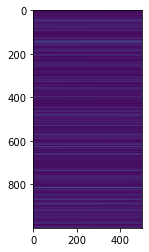

In [ ]:
plt.imshow(Qaa[:,4,:])